In [1]:
from functools import partial
from time import time

import cvxpy as cvx

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import numpy as np

from tqdm.auto import tqdm

In [2]:
def dynamics(s, u, beta=0.3, dt=0.1):
    """Evaluate the discrete-time dynamics of the system."""
    _, _, dx, dy = s
    ds = jnp.array(
        [
            dx,
            dy,
            u[0] - beta * dx * jnp.abs(dx),
            u[1] - beta * dy * jnp.abs(dy),
        ]
    )
    s_next = s + dt * ds
    return s_next

In [20]:
def signed_distances(s, centers, radii):
    """Compute signed distances to circular obstacles."""
    # print(centers)
    centers = jnp.reshape(centers, (-1, 2))
    # print(centers)
    radii = jnp.reshape(radii, (-1,))

    # PART (a): YOUR CODE BELOW ###############################################
    # INSTRUCTIONS: Compute the vector of signed distances to each obstacle.

    # d = NotImplementedError()
    
    d = jnp.linalg.norm(s[:2]-centers,2,axis=1)-radii

    # END PART (a) ############################################################
    return d

# Define constants
n = 4  # state dimension
m = 2  # control dimension
s0 = np.array([-1.0, -1.0, 0.0, 0.0])  # initial state
s_goal = np.array([1.0, 1.0, 0.0, 0.0])  # desired final state
T = 30  # total simulation time
P = 1e2 * np.eye(n)  # terminal state cost matrix
Q = 1e1 * np.eye(n)  # state cost matrix
R = 1e-2 * np.eye(m)  # control cost matrix
eps = 1e-3  # SCP convergence tolerance

# Set obstacle center points and radii
centers = np.array(
    [
        [-0.6, -0.4],
        [0.6, 0.1],
    ]
)
radii = np.array([0.5, 0.5])


centers = jnp.reshape(centers, (-1, 2))
# print(s0[:2], centers)
radii = jnp.reshape(radii, (-1,))

print(jnp.linalg.norm(s0[:2]-centers,2,axis=1)-radii)

signed_distances(s0, centers, radii)

[0.22111028 1.4416488 ]


Array([0.22111028, 1.4416488 ], dtype=float32)

In [21]:
s0

array([-1., -1.,  0.,  0.])

In [22]:
@partial(jax.jit, static_argnums=(0,))
@partial(jax.vmap, in_axes=(None, 0, 0))
def affinize(f, s, u):
    """Affinize the function `f(s, u)` around `(s, u)`."""
    # PART (b) ################################################################
    # INSTRUCTIONS: Use JAX to affinize `f` around `(s,u)` in two lines.

    A, B = jax.jacrev(f, argnums=(0,1))(s, u)
    # NotImplementedError()
    c = f(s, u)

    # END PART (b) ############################################################
    return A, B, c

In [27]:
def scp_iteration(f, d, s0, s_goal, s_prev, u_prev, P, Q, R):
    """Solve a single SCP sub-problem for the obstacle avoidance problem."""
    n = s_prev.shape[-1]  # state dimension
    m = u_prev.shape[-1]  # control dimension
    N = u_prev.shape[0]  # number of steps

    Af, Bf, cf = affinize(f, s_prev[:-1], u_prev)
    Af, Bf, cf = np.array(Af), np.array(Bf), np.array(cf)
    Ad, _, cd = affinize(
        lambda s, _: d(s), 
        s_prev, 
        jnp.concatenate((u_prev, u_prev[-1:]))
    )
    Ad, cd = np.array(Ad), np.array(cd)

    s_cvx = cvx.Variable((N + 1, n))
    u_cvx = cvx.Variable((N, m))

    # PART (e): YOUR CODE BELOW ###############################################
    # INSTRUCTIONS: Construct the convex SCP sub-problem.

    objective = 0.0
    objective =  cvx.quad_form(s_cvx[-1,:]-s_goal, P) #+ cost_stage_u cost_stage_s + 

    for i in range(N):
        objective += cvx.quad_form(s_cvx[i,:]-s_goal, Q)

    for i in range(N):
        objective += cvx.quad_form(u_cvx[i,:], R)

    constraints = []

    constraints += [ s_cvx[0,:] == s0 ] # Constraint 1: initial starting state is s0
    constraints += [Ad[i,:,:]@ s_cvx[i,:] + cd[i,:] - Ad[i,:,:] @ s_prev[i,:] >= 0 for i in range(N)] 
    constraints += [ s_cvx[i+1,:] == Af[i,:,:] @ s_cvx[i,:] + Bf[i,:,:] @ u_cvx[i,:] + cf[i,:] - Af[i,:,:] @ s_prev[i,:] - Bf[i,:,:] @ u_prev[i,:] for i in range(N)] # Constraint 5: Linearized Dynamics

    # END PART (e) ############################################################

    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    prob.solve()
    if prob.status != "optimal":
        raise RuntimeError("SCP solve failed. Problem status: " + prob.status)
    s = s_cvx.value
    u = u_cvx.value
    J = prob.objective.value
    return s, u, J

In [28]:
def solve_obstacle_avoidance_scp(
    f,
    d,
    s0,
    s_goal,
    N,
    P,
    Q,
    R,
    eps,
    max_iters,
    s_init=None,
    u_init=None,
    convergence_error=False,
):
    """Solve the obstacle avoidance problem via SCP."""
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension

    # Initialize trajectory
    if s_init is None or u_init is None:
        s = np.zeros((N + 1, n))
        u = np.zeros((N, m))
        s[0] = s0
        for k in range(N):
            s[k + 1] = f(s[k], u[k])
    else:
        s = np.copy(s_init)
        u = np.copy(u_init)

    # Do SCP until convergence or maximum number of iterations is reached
    converged = False
    J = np.zeros(max_iters + 1)
    J[0] = np.inf
    for i in range(max_iters):
        s, u, J[i + 1] = scp_iteration(f, d, s0, s_goal, s, u, P, Q, R)
        dJ = np.abs(J[i + 1] - J[i])
        if dJ < eps:
            converged = True
            break
    if not converged and convergence_error:
        raise RuntimeError("SCP did not converge!")
    return s, u

In [38]:
# Define constants
n = 4  # state dimension
m = 2  # control dimension
s0 = np.array([-1.0, -1.0, 0.0, 0.0])  # initial state
s_goal = np.array([1.0, 1.0, 0.0, 0.0])  # desired final state
T = 30  # total simulation time
P = 1e2 * np.eye(n)  # terminal state cost matrix
Q = 1e1 * np.eye(n)  # state cost matrix
R = 1e-2 * np.eye(m)  # control cost matrix
eps = 1e-3  # SCP convergence tolerance

# Set obstacle center points and radii
centers = np.array(
    [
        [-0.6, -0.4],
        [0.6, 0.1],
    ]
)
radii = np.array([0.5, 0.5])

# PART (g): CHANGE THE PARAMETERS BELOW #######################################

N = 15  # MPC horizon
N_scp = 2  # maximum number of SCP iterations

# END PART (g) ################################################################

f = dynamics
d = partial(signed_distances, centers=centers, radii=radii)
s_mpc = np.zeros((T, N + 1, n))
u_mpc = np.zeros((T, N, m))
s = np.copy(s0)
total_time = time()
total_control_cost = 0.0
s_init = None
u_init = None
for t in tqdm(range(T)):
    # PART (f): YOUR CODE BELOW ###############################################

    # Solve the MPC problem at time `t`
    # Hint: You should call `solve_obstacle_avoidance_scp` here
    s_mpc[t], u_mpc[t] = solve_obstacle_avoidance_scp(f, d, s, s_goal, N, P, Q, R, eps,max_iters=N_scp)

    # Push the state `s` forward in time with a closed-loop MPC input
    # Hint: You should call `f` here
    s = f(s, u_mpc[t][0, :])

    # END PART (f) ############################################################

    # Accumulate the actual control cost
    total_control_cost += u_mpc[t, 0].T @ R @ u_mpc[t, 0]

    # Use this solution to warm-start the next iteration
    u_init = np.concatenate([u_mpc[t, 1:], u_mpc[t, -1:]])
    s_init = np.concatenate(
        [s_mpc[t, 1:], f(s_mpc[t, -1], u_mpc[t, -1]).reshape([1, -1])]
    )
total_time = time() - total_time
print("Total elapsed time:", total_time, "seconds")
print("Total control cost:", total_control_cost)

  0%|          | 0/30 [00:00<?, ?it/s]

Total elapsed time: 10.25478744506836 seconds
Total control cost: 4.192077189760258


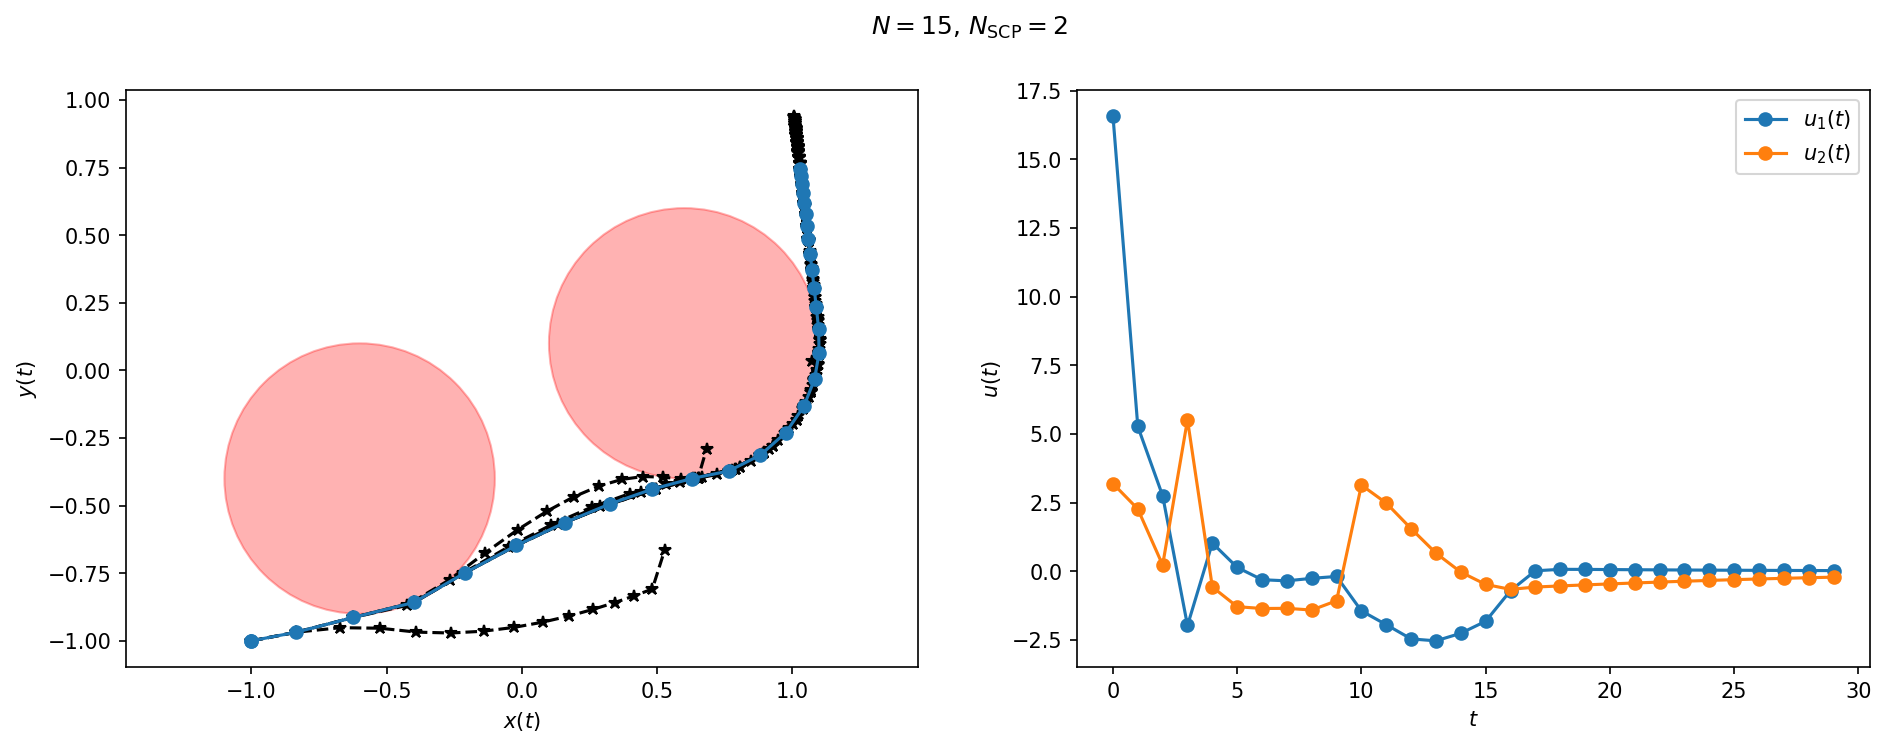

In [39]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(15, 5))
fig.suptitle("$N = {}$, ".format(N) + r"$N_\mathrm{SCP} = " + "{}$".format(N_scp))

for pc, rc in zip(centers, radii):
    ax[0].add_patch(plt.Circle((pc[0], pc[1]), rc, color="r", alpha=0.3))
for t in range(T):
    ax[0].plot(s_mpc[t, :, 0], s_mpc[t, :, 1], "--*", color="k")
ax[0].plot(s_mpc[:, 0, 0], s_mpc[:, 0, 1], "-o")
ax[0].set_xlabel(r"$x(t)$")
ax[0].set_ylabel(r"$y(t)$")
ax[0].axis("equal")

ax[1].plot(u_mpc[:, 0, 0], "-o", label=r"$u_1(t)$")
ax[1].plot(u_mpc[:, 0, 1], "-o", label=r"$u_2(t)$")
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$u(t)$")
ax[1].legend()

suffix = "_N={}_Nscp={}".format(N, N_scp)
plt.savefig("soln_obstacle_avoidance" + suffix + ".png", bbox_inches="tight")
plt.show()


### $N=5$ and $N_{scp}=5$
**Total elapsed time: 8.758649110794067 seconds**

**Total control cost: 6.32344996404277**

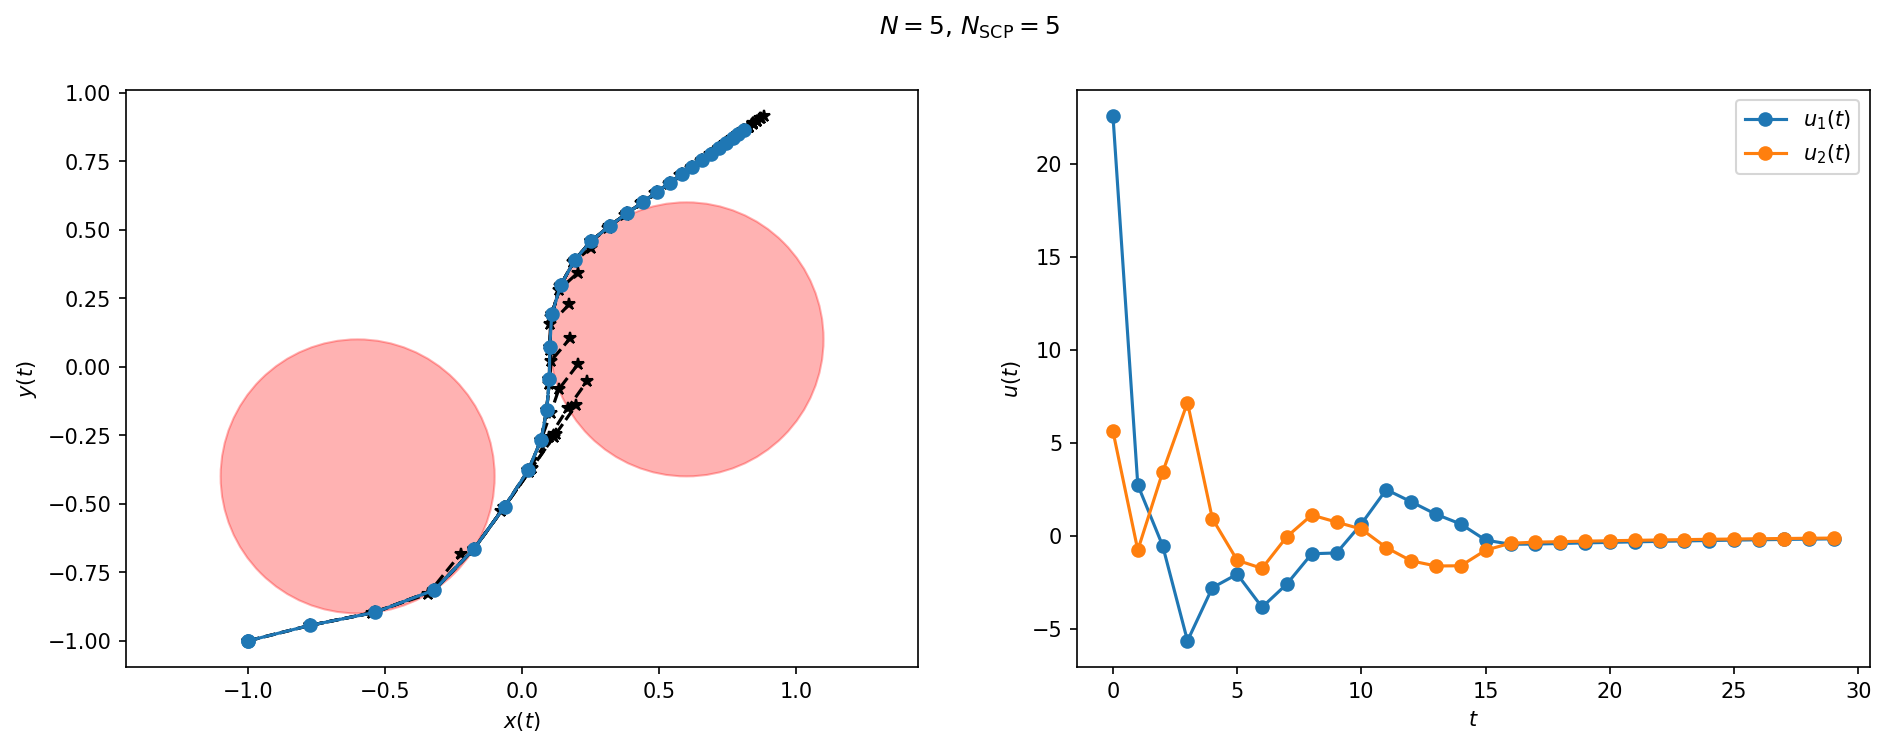

### $N=2$ and $N_{scp}=5$
**Infeasible**

### $N=5$ and $N_{scp}=2$
**Total elapsed time: 5.940040111541748 seconds**

**Total control cost: 4.427444064145336**

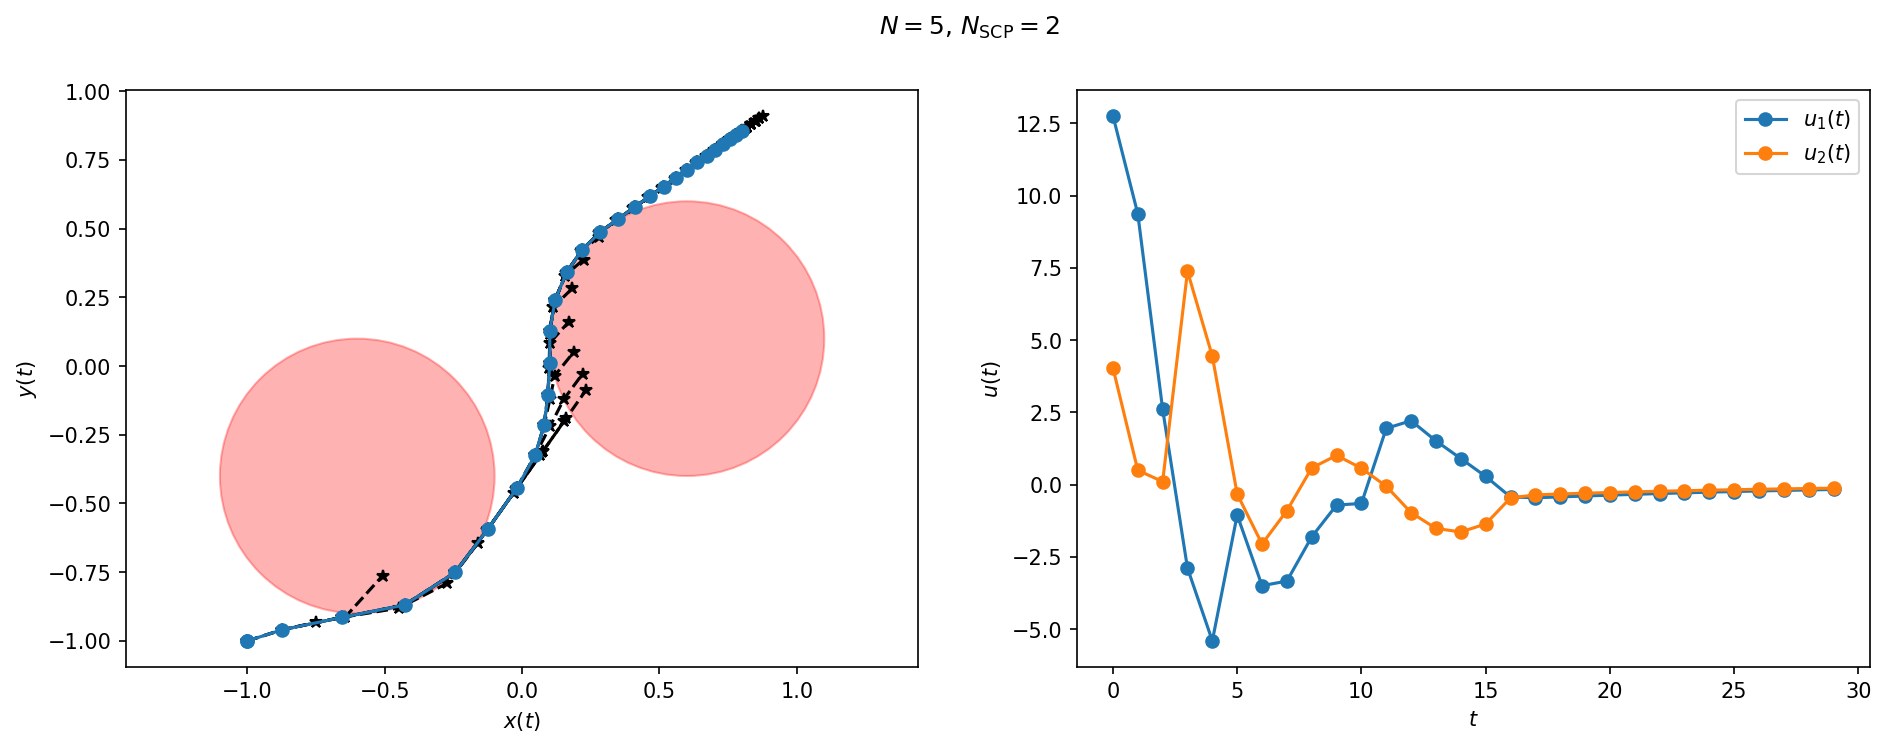

### $N=15$ and $N_{scp}=2$
**Total elapsed time: 10.25478744506836 seconds**

**Total control cost: 4.192077189760258**

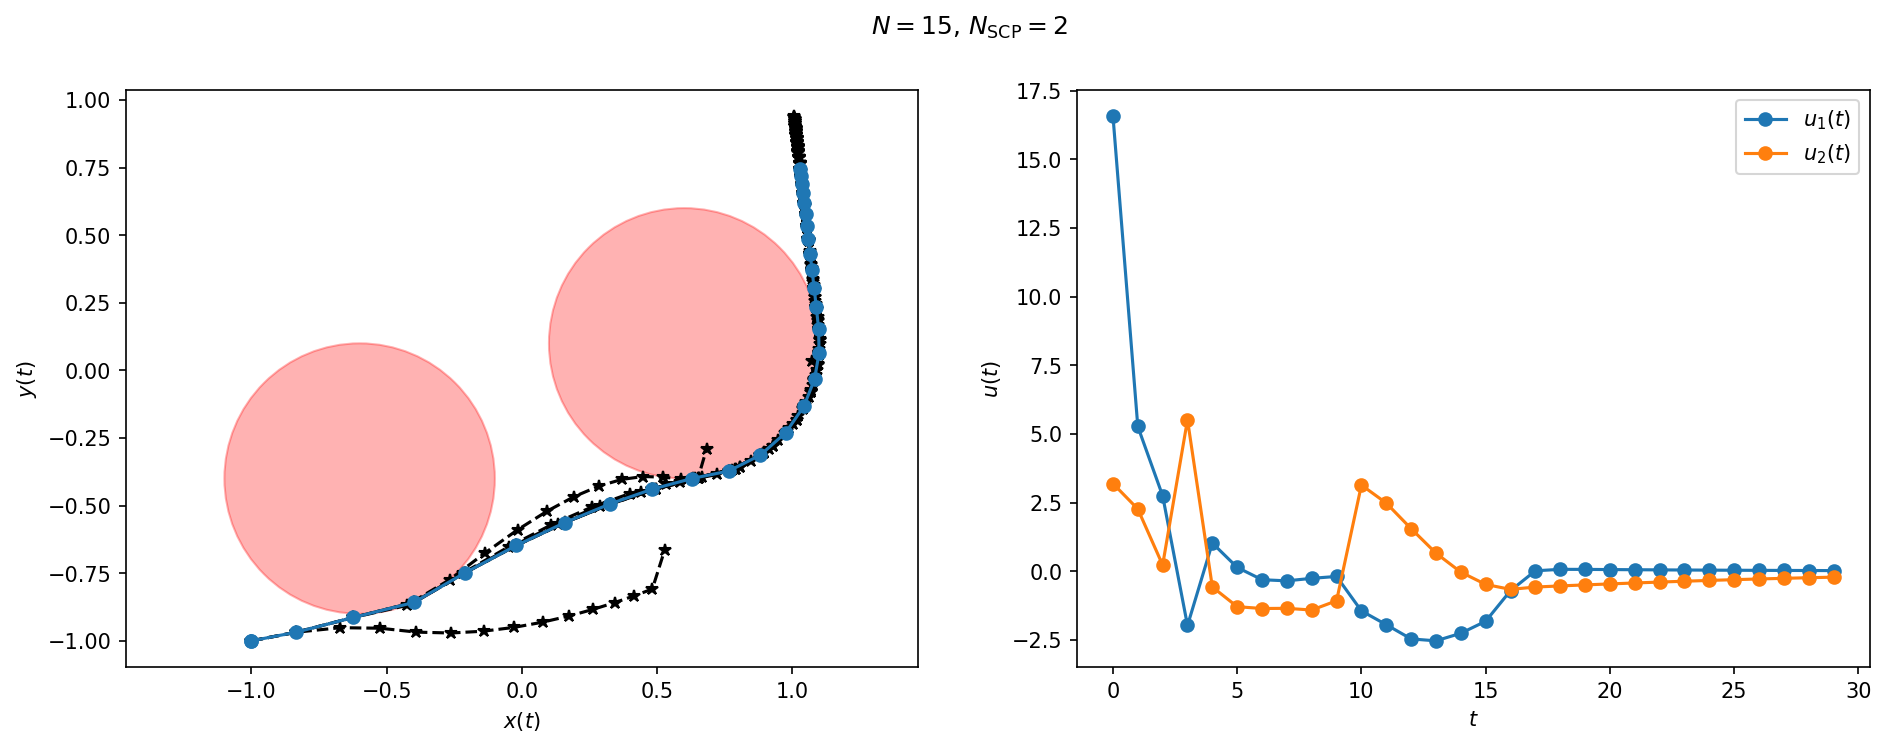


### Discussion
- for very short horizon, we ran into infeasibility pretty quickly
- between $N=5$ and $N=15$, the trajectory took two very different approaches. The former routed us in between the two obstacles, while the latter routed us around both obsticles. In comparison with the long-horizon, around-the-obstacle approach, the in-between obstacles approach resulted in a higher control cost by an addition of roughly two, but the solution time is also shorter by two seconds. We can therefore see the tradeoff between a long horizon for a more optimal solution and a short horizon for a faster computed solution.
- Changing the SCP iteration to a lower number did not result in a significant different trajectory from the higher iteration case. Though, it did shorten the computation by 3 seconds, and, luckily, it also happened to result in a solution with lower control effort